# Procurement & Supplier Management — Notebook

This notebook follows the `STEP nA / nB / nC` pattern.

- **df_raw** = raw procurement PO data
- **df_treat** = cleaned dataset after TREAT steps

Steps:
- STEP 1: SEE/TREAT/VERIFY structure
- STEP 2: SEE/TREAT/VERIFY missing dates
- STEP 3: SEE/TREAT/VERIFY outliers & suppliers
- STEP 4: VERIFY KPIs
- STEP 5: Descriptive analytics
- STEP 6: Diagnostic analytics
- STEP 7: Predictive logistic regression
- STEP 8: Prescriptive supplier allocation


In [1]:
# STEP 0 — imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline


In [2]:
# STEP 0B — load dataset
df_raw = pd.read_csv('https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/procurement_po_data.csv')
df_raw.head()



,PO_ID,Supplier,Lead_Time_Days,Unit_Price,Defect_Flag,Quantity,PO_Date,Delivery_Date
0,PO_001,A,10.8,10.5,1,357,2024-02-15,2024-02-25
1,PO_002,B,5.5,11.0,0,524,2024-02-19,2024-02-24
2,PO_003,A,14.5,10.2,0,339,2024-01-15,2024-01-29
3,PO_004,C,8.1,0.5,0,480,2024-02-18,2024-02-26
4,PO_005,Sup B,-12.2,10.2,0,578,2024-02-24,2024-02-24


## Helper Functions

We will use the following helper functions in multiple steps:

- `missing_report(df)`
- `step1_check_structure(df)`
- `step2_check_missing_and_dates(df)`
- `step3_check_outliers_and_suppliers(df)`
- `step4_check_verify_kpis(df, promised_lead_time=10)`


In [3]:
def missing_report(df):
    """Print count of missing values per column."""
    print(df.isna().sum())
    print()

def step1_check_structure(df):
    print("dtypes:\n", df.dtypes)
    print("\nDuplicate PO_ID count:", df.duplicated('PO_ID').sum())
    if 'Lead_Time_Days' in df.columns:
        print("Negative/zero lead times:", (df['Lead_Time_Days']<=0).sum())
    print("\nUnique suppliers:", df['Supplier'].unique())
    print()

def step2_check_missing_and_dates(df):
    print("Missing Delivery_Date:", df['Delivery_Date'].isna().sum())
    if 'Lead_Time_Days' in df.columns:
        print("Missing Lead_Time_Days:", df['Lead_Time_Days'].isna().sum())
    print()

def step3_check_outliers_and_suppliers(df):
    if 'Lead_Time_Days' in df.columns:
        print(df['Lead_Time_Days'].describe())
        print("Lead times > 45 days:", (df['Lead_Time_Days']>45).sum())
    print("\nSuppliers frequency:")
    print(df['Supplier'].value_counts())
    print()

def step4_check_verify_kpis(df, promised_lead_time=10):
    df = df.copy()
    df['Late_Flag'] = (df['Lead_Time_Days'] > promised_lead_time).astype(int)
    grp = df.groupby('Supplier')
    kpi = pd.DataFrame(index=grp.size().index)
    kpi['OTD%'] = (1 - grp['Late_Flag'].mean()) * 100
    kpi['Mean_LT'] = grp['Lead_Time_Days'].mean()
    kpi['Std_LT'] = grp['Lead_Time_Days'].std()
    kpi['CV%'] = kpi['Std_LT'] / kpi['Mean_LT'] * 100
    kpi['DefectRate%'] = grp['Defect_Flag'].mean() * 100
    print(kpi)
    return kpi


## STEP 1 — SEE / TREAT / VERIFY: Structure
Check structure of df_raw: dtypes, duplicates, impossible lead times, supplier names.


In [4]:
# STEP 1A — SEE structure
step1_check_structure(df_raw)


dtypes:
 PO_ID              object
Supplier           object
Lead_Time_Days    float64
Unit_Price        float64
Defect_Flag         int64
Quantity            int64
PO_Date            object
Delivery_Date      object
dtype: object

Duplicate PO_ID count: 0
Negative/zero lead times: 2

Unique suppliers: ['A' 'B' 'C' 'Sup B' 'Supp A' 'supA']



In [5]:
# STEP 1B — TREAT structure
df_treat = df_raw.copy()

mapping = {
    'A': 'A', 'Supp A': 'A', 'supA': 'A',
    'B': 'B', 'Sup B': 'B',
    'C': 'C'
}
df_treat['Supplier'] = df_treat['Supplier'].map(mapping)

df_treat['PO_Date'] = pd.to_datetime(df_treat['PO_Date'])
df_treat['Delivery_Date'] = pd.to_datetime(df_treat['Delivery_Date'])

df_treat['Lead_Time_Days'] = (df_treat['Delivery_Date'] - df_treat['PO_Date']).dt.days
df_treat.loc[df_treat['Lead_Time_Days'] <= 0, 'Lead_Time_Days'] = np.nan

df_treat = df_treat.drop_duplicates(subset='PO_ID', keep='first')


In [6]:
# STEP 1C — VERIFY structure
step1_check_structure(df_treat)


dtypes:
 PO_ID                     object
Supplier                  object
Lead_Time_Days           float64
Unit_Price               float64
Defect_Flag                int64
Quantity                   int64
PO_Date           datetime64[ns]
Delivery_Date     datetime64[ns]
dtype: object

Duplicate PO_ID count: 0
Negative/zero lead times: 0

Unique suppliers: ['A' 'B' 'C']



## STEP 2 — SEE / TREAT / VERIFY: Missing Dates & Lead Times
Handle missing Delivery_Date and Lead_Time_Days using median lead time per supplier.


In [7]:
# STEP 2A — SEE missingness
missing_report(df_treat)
step2_check_missing_and_dates(df_treat)


PO_ID             0
Supplier          0
Lead_Time_Days    7
Unit_Price        0
Defect_Flag       0
Quantity          0
PO_Date           0
Delivery_Date     5
dtype: int64

Missing Delivery_Date: 5
Missing Lead_Time_Days: 7



In [8]:
# STEP 2B — TREAT missing Delivery_Date
median_lt = df_treat.groupby('Supplier')['Lead_Time_Days'].median()

mask_missing_del = df_treat['Delivery_Date'].isna()
df_treat.loc[mask_missing_del, 'Delivery_Date'] = (
    df_treat.loc[mask_missing_del, 'PO_Date'] +
    pd.to_timedelta(df_treat.loc[mask_missing_del, 'Supplier'].map(median_lt), unit='D')
)

df_treat['Lead_Time_Days'] = (df_treat['Delivery_Date'] - df_treat['PO_Date']).dt.days


In [9]:
median_lt

Supplier
A    9.0
B    9.0
C    9.0
Name: Lead_Time_Days, dtype: float64

In [10]:
# STEP 2C — VERIFY missingness
missing_report(df_treat)
step2_check_missing_and_dates(df_treat)


PO_ID             0
Supplier          0
Lead_Time_Days    0
Unit_Price        0
Defect_Flag       0
Quantity          0
PO_Date           0
Delivery_Date     0
dtype: int64

Missing Delivery_Date: 0
Missing Lead_Time_Days: 0



## STEP 3 — SEE / TREAT / VERIFY: Outliers & Supplier Labels
Check lead-time outliers (> 45 days) and ensure Supplier ∈ {A,B,C}.


In [11]:
# STEP 3A — SEE outliers & suppliers
step3_check_outliers_and_suppliers(df_treat)


count    120.000000
mean       9.116667
std        3.194489
min        0.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       16.000000
Name: Lead_Time_Days, dtype: float64
Lead times > 45 days: 0

Suppliers frequency:
Supplier
A    59
B    41
C    20
Name: count, dtype: int64



In [12]:
# STEP 3B — TREAT outliers & suppliers
df_treat = df_treat[df_treat['Lead_Time_Days'] <= 45]


In [13]:
# STEP 3C — VERIFY outliers & suppliers
step3_check_outliers_and_suppliers(df_treat)


count    120.000000
mean       9.116667
std        3.194489
min        0.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       16.000000
Name: Lead_Time_Days, dtype: float64
Lead times > 45 days: 0

Suppliers frequency:
Supplier
A    59
B    41
C    20
Name: count, dtype: int64



## STEP 4 — VERIFY: KPI Stability
Compute OTD%, CV%, DefectRate% per supplier to verify dataset stability.


In [14]:
# STEP 4A — Compute KPI table
promised_lead_time = 10
df_treat['Late_Flag'] = (df_treat['Lead_Time_Days'] > promised_lead_time).astype(int)
kpi_table = step4_check_verify_kpis(df_treat, promised_lead_time=promised_lead_time)


               OTD%   Mean_LT    Std_LT        CV%  DefectRate%
Supplier                                                       
A         67.796610  9.423729  2.711428  28.772346    13.559322
B         70.731707  8.560976  3.968934  46.360770     9.756098
C         70.000000  9.350000  2.700390  28.881175    25.000000


In [15]:
# STEP 4B — Inspect KPI table
kpi_table


,OTD%,Mean_LT,Std_LT,CV%,DefectRate%
Supplier,,,,,
A,67.796610,9.423729,2.711428,28.772346,13.559322
B,70.731707,8.560976,3.968934,46.360770,9.756098
C,70.000000,9.350000,2.700390,28.881175,25.000000


### STEP 4C — Interpretation (student)
- Which supplier looks most stable?
- Who has the highest OTD% and lowest CV%?


## STEP 5 — Descriptive Analytics
Build a supplier scorecard: lead time, defects, price behaviour.


In [ ]:
# STEP 5A — Descriptive KPIs
grp = df_treat.groupby('Supplier')
desc = grp['Lead_Time_Days'].agg(['mean', 'std']).rename(columns={'mean':'Mean_LT','std':'Std_LT'})
desc['CV%'] = desc['Std_LT']/desc['Mean_LT']*100
desc['DefectRate%'] = grp['Defect_Flag'].mean()*100
desc['DefectRate_std'] = grp['Defect_Flag'].std()
desc['Price_Mean'] = grp['Unit_Price'].mean()
desc['Price_Std'] = grp['Unit_Price'].std()
desc


,Mean_LT,Std_LT,CV%,DefectRate%,Price_Mean,Price_Std
Supplier,,,,,,
A,9.423729,2.711428,28.772346,13.559322,14.115254,13.558034
B,8.560976,3.968934,46.360770,9.756098,14.582927,13.623452
C,9.350000,2.700390,28.881175,25.000000,19.785000,18.034478


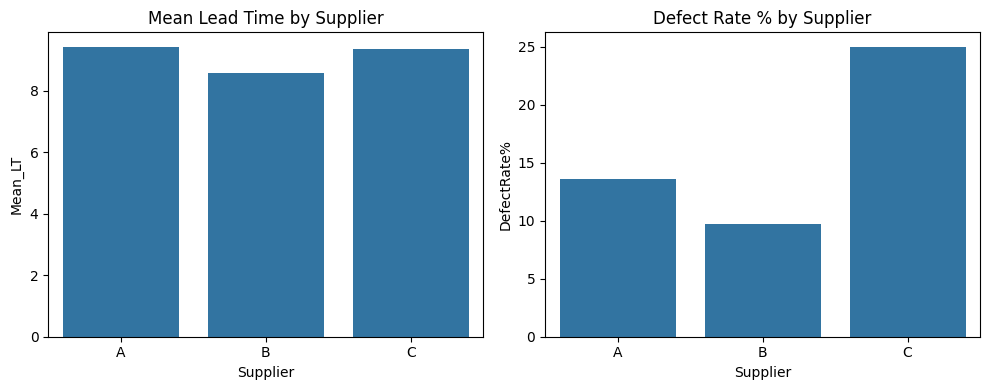

In [ ]:
# STEP 5B — Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(10,4))
sns.barplot(x=desc.index, y='Mean_LT', data=desc, ax=axes[0])
axes[0].set_title('Mean Lead Time by Supplier')

sns.barplot(x=desc.index, y='DefectRate%', data=desc, ax=axes[1])
axes[1].set_title('Defect Rate % by Supplier')


sns.barplot(x=desc.index, y='Price_Mean', data=desc, ax=axes[2])
axes[2].set_title('Mean Unit Price by Supplier')

plt.tight_layout()
plt.show()


### STEP 5C — Interpretation (student)
- Summarise which supplier is fastest, most reliable, and cheapest.


## STEP 6 — Diagnostic Analytics
Explain **why** suppliers behave differently (variance drivers, relationships).


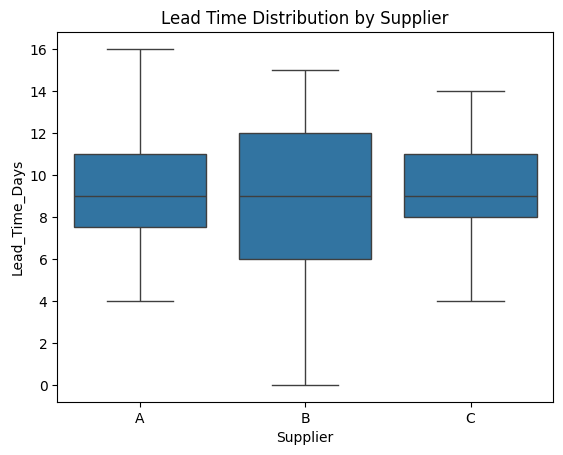

In [20]:
# STEP 6A — Lead time variance by supplier
sns.boxplot(x='Supplier', y='Lead_Time_Days', data=df_treat)
plt.title('Lead Time Distribution by Supplier')
plt.show()


In [21]:
# STEP 6B — Relationship between defects and lead time
df_treat.groupby('Defect_Flag')['Lead_Time_Days'].mean()


Defect_Flag
0    9.184466
1    8.705882
Name: Lead_Time_Days, dtype: float64

### STEP 6C — Interpretation (student)
- Does higher lead time correlate with more defects?
- Are some suppliers 'too cheap' and unstable?


## STEP 7 — Predictive Analytics (Logistic Regression)
Model Late_Flag using Lead_Time_Days, Defect_Flag, Supplier_Index, Unit_Price.


In [22]:
# STEP 7A — Feature preparation
df_model = df_treat.copy()
df_model['Late_Flag'] = (df_model['Lead_Time_Days'] > 10).astype(int)
supplier_map = {s:i for i,s in enumerate(sorted(df_model['Supplier'].dropna().unique()))}
df_model['Supplier_Index'] = df_model['Supplier'].map(supplier_map)
X = df_model[['Lead_Time_Days','Defect_Flag','Supplier_Index','Unit_Price']]
y = df_model['Late_Flag']


In [23]:
# STEP 7B — Train logistic regression and predict probabilities
lr = LogisticRegression(max_iter=1000)
lr.fit(X, y)
df_model['Late_Prob'] = lr.predict_proba(X)[:,1]
df_model[['Supplier','Lead_Time_Days','Late_Flag','Late_Prob']].head()


,Supplier,Lead_Time_Days,Late_Flag,Late_Prob
0,A,10,0,1.096926e-01
1,B,5,0,1.161665e-07
2,A,14,1,9.999190e-01
3,C,8,0,3.485392e-04
4,B,0,0,9.444275e-14


### STEP 7C — Interpretation (student)
- Which features increase late probability?
- Which supplier has lowest average Late_Prob?


## STEP 8 — Prescriptive Decision (Supplier Allocation)
Combine KPIs and Late_Prob to recommend sourcing allocation.


In [24]:
# STEP 8A — Aggregate supplier performance
summary = df_model.groupby('Supplier').agg(
    OTD=('Late_Flag', lambda x: (1-x.mean())*100),
    Mean_LT=('Lead_Time_Days','mean'),
    CV_LT=('Lead_Time_Days', lambda x: x.std()/x.mean()*100),
    DefectRate=('Defect_Flag', lambda x: x.mean()*100),
    Price=('Unit_Price','mean'),
    Late_Prob=('Late_Prob','mean')
)
summary


,OTD,Mean_LT,CV_LT,DefectRate,Price,Late_Prob
Supplier,,,,,,
A,67.796610,9.423729,28.772346,13.559322,14.115254,0.314360
B,70.731707,8.560976,46.360770,9.756098,14.582927,0.310083
C,70.000000,9.350000,28.881175,25.000000,19.785000,0.286964


In [25]:
# STEP 8B — Choose allocation (example)
allocation_proposal = {'A': 30, 'B': 70, 'C': 0}
allocation_proposal


{'A': 30, 'B': 70, 'C': 0}

### STEP 8C — Managerial summary (student)
- Write 3–5 bullet points as advice to a Procurement Manager.
